In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [4]:
import cupy as cp

In [5]:
PROJECT_PATH = '../'
SRBF_PATH = "/scratch/ceph/swei20/data/dnn/BHB/rbf_Blue_R2300_1k.h5"
BLUE_PATH = "/scratch/ceph/szalay/swei20/AE/norm_flux_Blue_R2300.h5"
REDM_PATH = "/scratch/ceph/szalay/swei20/AE/norm_flux_RedM_R5000.h5"
sys.path.insert(0, PROJECT_PATH)

### Load data

In [6]:
with h5py.File(BLUE_PATH, 'r') as f:
    flux0 = f['flux'][()]
    para0 = f['para'][()]
    wave0 = f['wave'][()]

In [7]:
flux0.shape, wave0.shape

((116614, 5368), (5368,))

In [8]:
from lv.base.dataloader_c import DataLoader

In [9]:
ds = DataLoader()

In [10]:
ds.prepare_data ("Blue", "B", flux0, wave0, para0, fix_CO=0)

flux: 3300, wave: 5368


# find mask

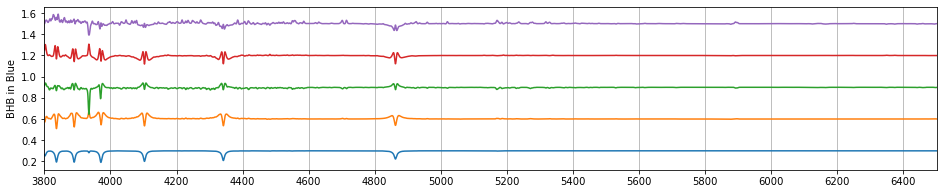

In [11]:
ds.init_pcp()

In [12]:
ds.flux.shape

(3300, 5368)

In [16]:
_,w,v =cp.linalg.svd(ds.flux, full_matrices=0)

(0.0, 25.0)

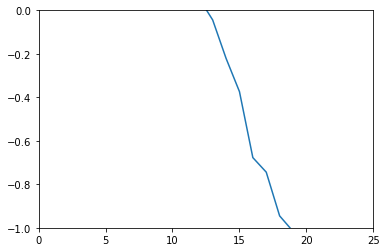

In [22]:
plt.plot(np.log(cp.asnumpy(w)))
plt.ylim(-1,0)
plt.xlim(0,25)

In [33]:
# k,q,prom = 10, 0.75, 0.1
k,q,prom = 5, 0.8, 0.01
peaks, prop, nvv= ds.get_peaks(k=k,q=q,prom=prom)

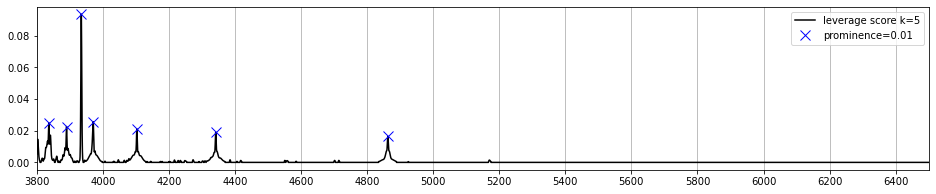

In [34]:
ds.plot_peaks(nvv, peaks, k, prom)

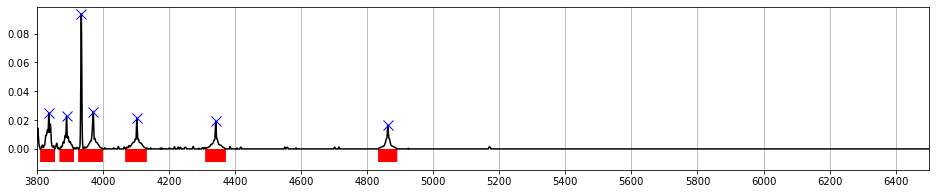

In [35]:
ds.plot_mask_from_peaks(peaks, prop, nvv)

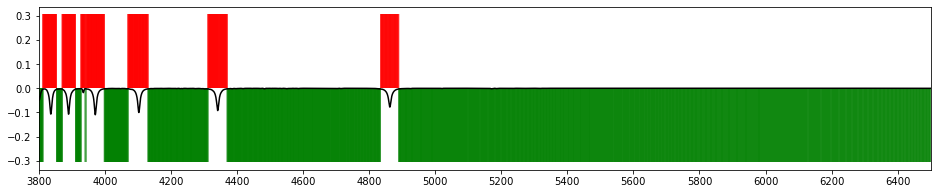

In [36]:
ds.plot_MN_mask(0)

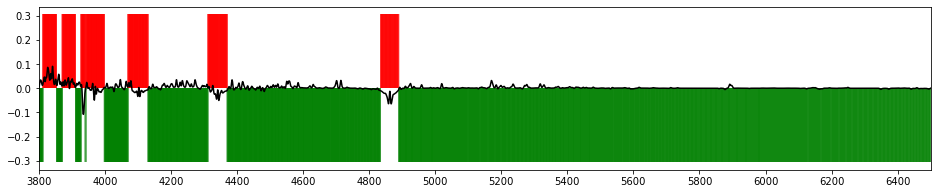

In [37]:
ds.plot_MN_mask(4)

In [39]:
# ds.plot_lick()

In [40]:
ds.get_MN(ds.nmask, top=5)

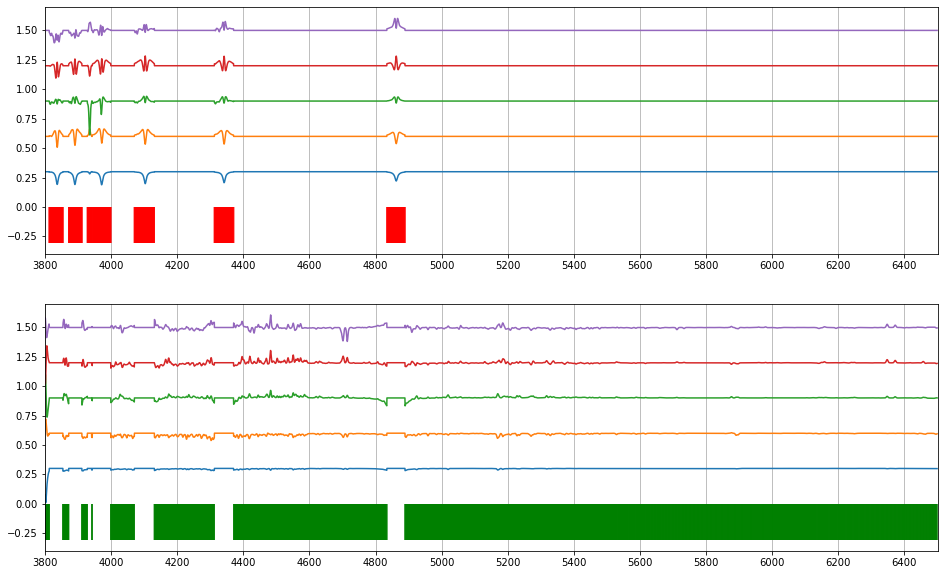

In [41]:
ds.plot_MN(step=0.3)

In [46]:
mu = 1.0 / ds.Mw[2]
ML, MS, MLv, MSv = ds._pcp(ds.M, delta=1e-5, mu=mu, lam=None, norm=None, maxiter=1000)

mu 0.03, lambda 0.0174, norm 465616.8


L(31, 780), S(30, 780)


(31, 5368)


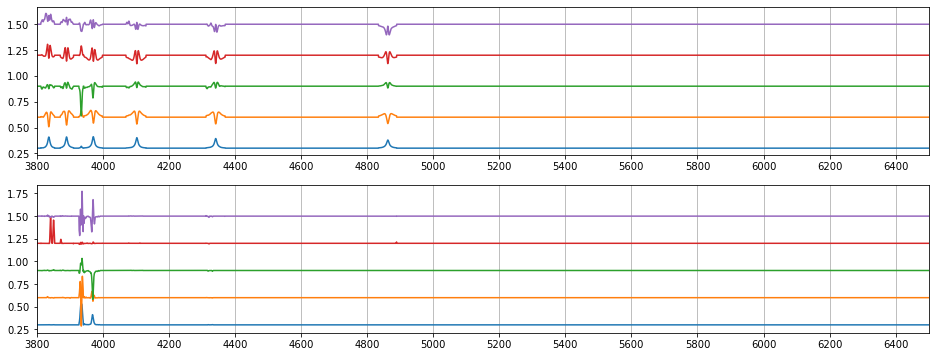

In [48]:
nMLv, nMSv =ds.eval_pcp(MLv, MSv)

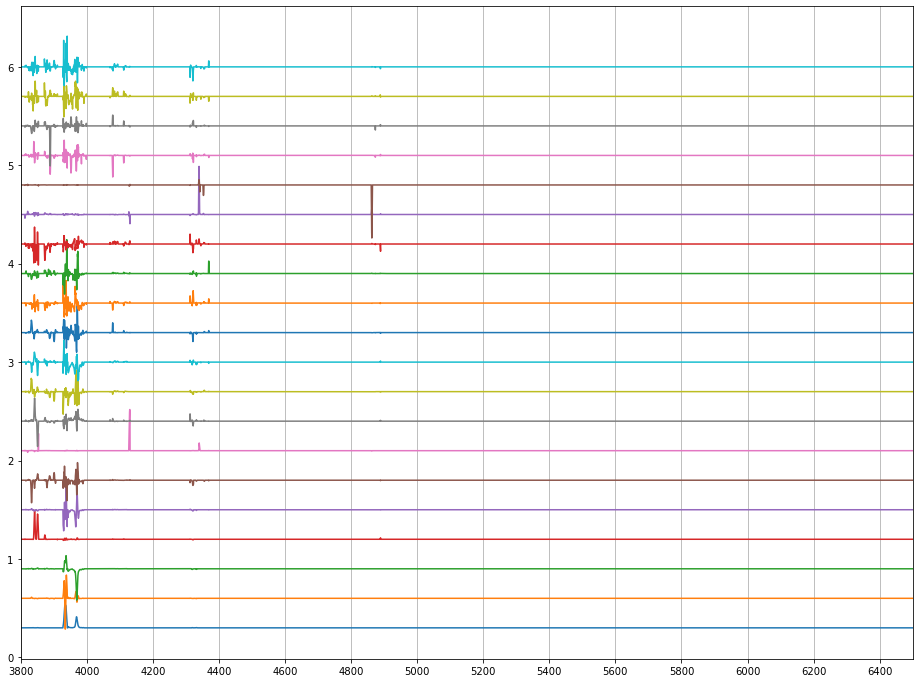

In [49]:
ds.plot_V(nMSv, top=20)

In [52]:
mu = 1.0 / ds.Nw[2]
NL, NS, NLv, NSv = ds._pcp(ds.N, delta=1e-6, mu=mu, lam=None, norm=None, maxiter=1000)

mu 0.12, lambda 0.0174, norm 13353.8


L(61, 4588), S(30, 4588)


(61, 5368)


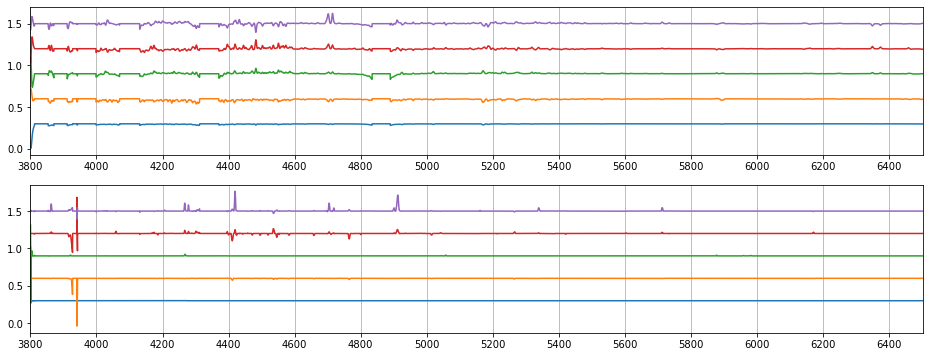

In [53]:
nNLv, nNSv = ds.eval_pcp(NLv, NSv, isM=0)

In [54]:
ds.pcp_transform(MLv, MSv, NLv, NSv, top=20)

In [55]:
ds.pcp_np(save=1)

In [56]:
ds.npcpFlux.shape

(3300, 80)

In [58]:
from sklearn.ensemble import RandomForestRegressor

In [59]:
rf = RandomForestRegressor(max_depth=50, random_state=0, n_estimators=100, max_features=30)

In [61]:
ds.npcpFlux.shape

(3300, 80)

In [62]:
idx=1
rf.fit(ds.npcpFlux[:,:40], ds.para[:,idx])

RandomForestRegressor(max_depth=50, max_features=30, random_state=0)

In [65]:
ds.pnames=["Teff", "Logg", "[M/H]", "[C/M]", "[a/M]"]

In [76]:
rf.feature_importances_.argsort()[::-1]

array([28, 32,  4, 22, 20, 35, 18,  8, 27, 34, 39, 29, 37, 30,  1, 15, 33,
        3, 31, 24,  0, 36, 21,  5, 38, 23, 25, 26, 10, 11,  6, 17,  7, 19,
        2, 14,  9, 12, 16, 13])

Text(0.5, 1.0, 'log feature importance for Logg')

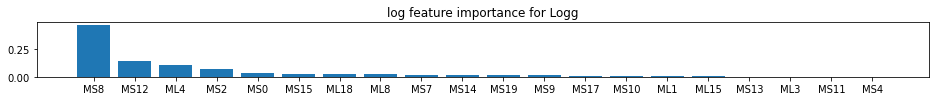

In [78]:
sdx = rf.feature_importances_.argsort()[::-1][:20]
plt.figure(figsize=(16,1), facecolor="w")
plt.bar([ds.Xname[sdx[i]] for i in range(len(sdx))], rf.feature_importances_[sdx], log=0)
plt.title(f"log feature importance for {ds.pnames[idx]}")

In [89]:
ds.nXv.shape

(80, 5368)

In [232]:
# plt.figure(figsize=(16,1))
# plt.vlines(ds.nwave[ds.nmask], ymin=0,ymax=0.1,color='r')
# ds.get_wave_axis(ax=plt.gca())
# ds.plot_lick()


In [349]:
from lv.base.baseLL import get_LL

In [427]:
mat = get_LL("gfallvac08oct17.dat")

(2305268, 3)


In [544]:
ll

,W,I,Z,Q
0,18.348,-6.079,8,5
1,18.348,-5.951,8,5
2,19.008,-8.163,8,5
3,19.008,-7.543,8,5
4,19.032,-7.017,8,5
...,...,...,...,...
2305263,9950248.756,-4.223,28,1
2305264,9957184.108,-14.792,12,0
2305265,9960159.363,-7.739,25,1
2305266,9960159.363,-4.230,28,1


In [545]:
ll.to_csv("/scratch/ceph/szalay/swei20/LL/kurucz/gfall_vac_A.csv")

In [716]:
ll0

,W,I,Z,Q
846786,3800.000,-2.796,25,1
846787,3800.009,0.113,29,1
846788,3800.022,-2.354,42,0
846789,3800.026,-5.929,20,0
846790,3800.028,-7.289,24,1
...,...,...,...,...
1657137,12599.868,-3.430,56,0
1657138,12599.879,-4.471,41,0
1657139,12599.922,-0.660,56,0
1657140,12599.949,-4.471,41,0


In [546]:
ll0 = ll[(ll["W"] >= 3800) & (ll["W"]<=12600)]

In [547]:
ll0.to_csv("/scratch/ceph/szalay/swei20/LL/kurucz/gfall_vac_3800A_12600A.csv")

In [548]:
for W in ds.Ws.values():
    ll_w = ll0[(ll0["W"] >= W[0]) & (ll0["W"]<=W[1])]
    print(ll_w)
    ll_w.to_csv(f"/scratch/ceph/szalay/swei20/LL/kurucz/gfall_vac_{W[3]}.csv", index=0)

                W      I   Z  Q
846786   3800.000 -2.796  25  1
846787   3800.009  0.113  29  1
846788   3800.022 -2.354  42  0
846789   3800.026 -5.929  20  0
846790   3800.028 -7.289  24  1
...           ...    ...  .. ..
1274393  6499.947 -2.087  10  0
1274394  6499.952 -2.847  28  0
1274395  6499.960 -0.770  57  0
1274396  6499.976 -3.406  23  0
1274397  6499.990 -0.534   7  0

[427612 rows x 4 columns]
                W      I   Z  Q
1250659  6300.022 -3.339  41  0
1250660  6300.028 -3.901  26  1
1250661  6300.042 -2.379   7  0
1250662  6300.044 -3.339  41  0
1250663  6300.046 -0.046  10  2
...           ...    ...  .. ..
1528236  9699.723 -5.468  10  0
1528237  9699.785 -2.438  26  1
1528238  9699.799 -1.805  26  1
1528239  9699.855 -8.762   8  0
1528240  9699.857 -4.461  24  1

[277582 rows x 4 columns]
                W      I   Z  Q
1335503  7100.010 -0.478  39  0
1335504  7100.013 -2.861  27  0
1335505  7100.014 -7.426  16  0
1335506  7100.018 -2.861  27  0
1335507  7100.034 

In [549]:
LL = ds.get_LL()

In [550]:
LL

,W,I,Z,Q
0,3800.000,-2.796,25,1
1,3800.009,0.113,29,1
2,3800.022,-2.354,42,0
3,3800.026,-5.929,20,0
4,3800.028,-7.289,24,1
...,...,...,...,...
427607,6499.947,-2.087,10,0
427608,6499.952,-2.847,28,0
427609,6499.960,-0.770,57,0
427610,6499.976,-3.406,23,0


In [736]:
LL1=LL[(LL["I"]>-0.3) & (LL["Z"] < 27) & ((LL["Z"] == 1) | (LL["Q"] > 0))]

In [769]:
ZLs = [1,6,7,8,11,12,20,26]


In [783]:
LLZ = LL[LL["Z"].isin(ZLs)]

In [791]:
LLZI = LLZ[LLZ["I"]>-0.2]

In [792]:
LLZI

,W,I,Z,Q
1502,3806.422,0.313,26,0
1759,3807.776,0.017,26,0
2976,3813.632,-0.143,8,1
3014,3813.883,-0.144,6,1
3637,3816.923,0.232,26,0
...,...,...,...,...
426521,6490.195,0.099,26,1
426886,6493.457,-0.114,26,1
427108,6495.576,0.140,20,0
427264,6497.005,0.031,26,1


In [793]:
zz="0 H He Li Be B C N O F Ne Na Mg Al Si P S Cl Ar K Ca Sc Ti V Cr Mn Fe"
Znames = zz.split(" ")

In [794]:

def plot_LL(df, gp=1, rng=[3800, 6500], ax=None):
#     if gp==1: 
    dff = df[(df["W"] >=rng[0]) & (df["W"] <=rng[1])]
    Z=dff["Z"].values
    W=dff["W"].values
#     c = cm.gist_rainbow((c-np.min(c))/(np.max(c)-np.min(c)))
    c = cm.gist_rainbow((Z-1)/(27-1))
    if ax is None: ax = plt.subplots(figsize=(20,2))[1]
    for i in range(len(W)):
        ax.axvline(W[i], color=c[i], label=f"{Znames[Z[i]]}", alpha=0.5)
    ax.set_xlim(rng)
    ds.set_unique_legend(ax, fix_ncol=0)
    return dff


In [796]:
# ['0', 'H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl',
#  'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe']

(3800.0, 6500.0)

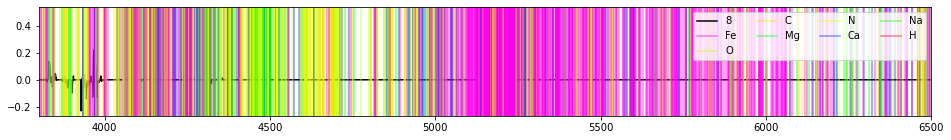

In [788]:
ds.plot_nv(nMSv, 8,fineW=1, fs=2)
rng=[3800, 6500]
dff = plot_LL(LLZI, rng=rng, ax=plt.gca())
plt.plot(0,0.5)
plt.xlim(rng)


In [747]:
ds.nXv.shape

(80, 5368)

In [748]:
sdx[:10]

array([28, 32,  4, 22, 20, 35, 18,  8, 27, 34])

In [800]:
LLZI["I"].min()

-0.199

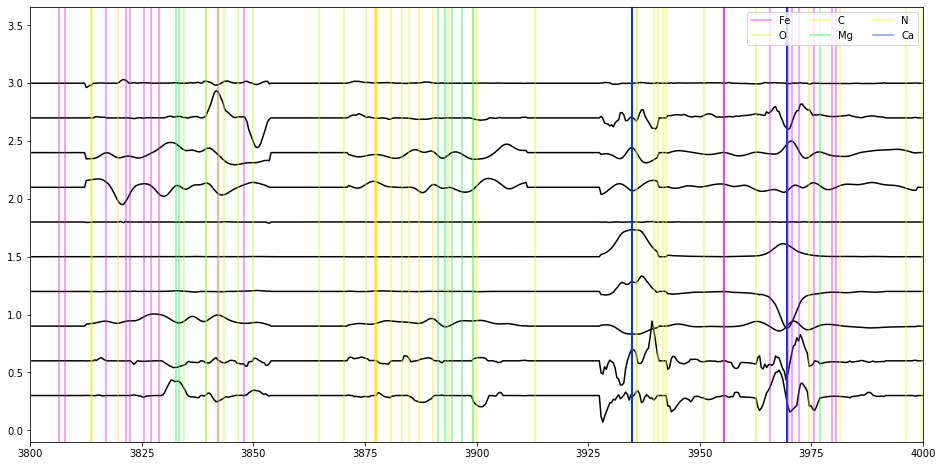

In [798]:
rng=[3800,4000]
ds.plot_IV(sdx[:10], top=10)
dff0 = plot_LL(LLZI, rng=rng, ax=plt.gca())


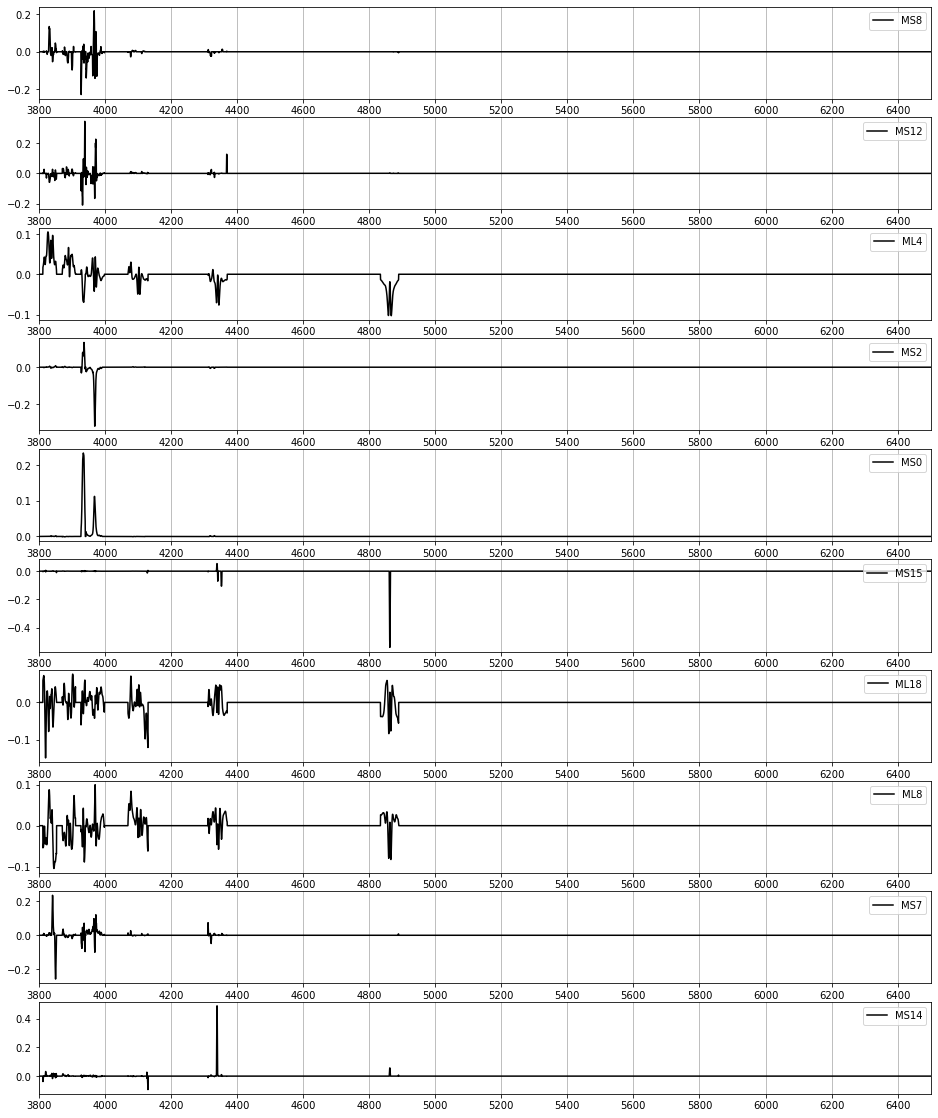

In [754]:
ds.plot_nvs(ds.nXv, sdx[:10], ds.Xname)

(3930.0, 3972.0)

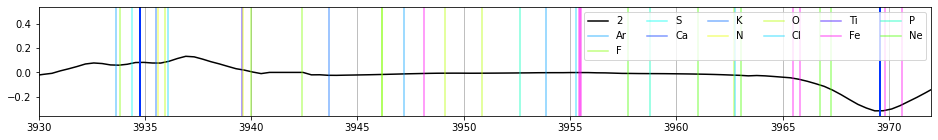

In [745]:
ds.plot_nv(nMSv, 2,fineW=1, fs=2)
rng=[3930, 3972]
dff0 = plot_LL(dff, rng=rng, ax=plt.gca())
plt.plot(0,0.5)
plt.xlim(rng)

(3925.0, 3930.0)

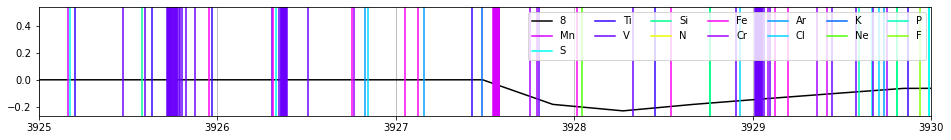

In [702]:
ds.plot_nv(nMSv, 8,fineW=1, fs=2)
rng=[3925, 3930]
dff0 = plot_LL(dff, rng=rng, ax=plt.gca())
plt.plot(0,0.5)
plt.xlim(rng)

(3932.0, 4000.0)

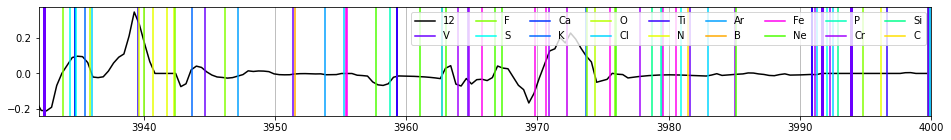

In [677]:
ds.plot_nv(nMSv, 12,fineW=1, fs=2)
rng=[3932, 4000]
dff = plot_LL(dff, rng=rng, ax=plt.gca())
plt.xlim(rng)

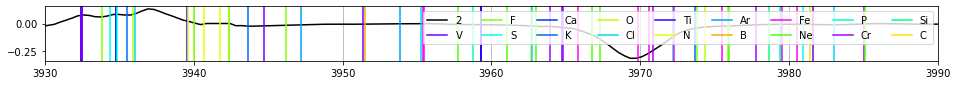

In [678]:
ds.plot_nv(nMSv, 2,fineW=1)
rng=[3930,3990]
plt.xlim(rng)
dff = plot_LL(LL1, rng=rng, ax=plt.gca())
# plt.axvline(3969.59 , label="Ca II" )

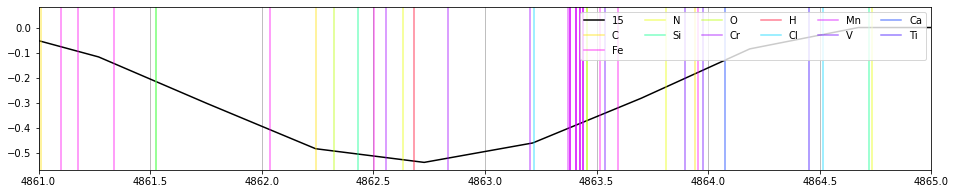

In [714]:
ds.plot_nv(nMSv, 15,fineW=1, fs=3)
rng=[4861,4865]
plt.xlim(rng)
dff = plot_LL(LL1, rng=rng, ax=plt.gca())
# plt.axvline(3969.59 , label="Ca II" )

In [724]:
LL1[(LL1["Z"]==20)& (LL1["W"]>3930)&(LL1["W"]<3980)]

,W,I,Z,Q
28698,3931.997,-0.952,20,1
29250,3934.766,0.111,20,1
29251,3934.767,0.111,20,1
29252,3934.768,0.111,20,1
29253,3934.769,0.111,20,1
29255,3934.771,0.111,20,1
29256,3934.773,0.111,20,1
29257,3934.775,0.111,20,1
29259,3934.778,0.111,20,1
29260,3934.782,0.111,20,1


In [680]:
dff

,W,I,Z,Q
28769,3932.437,-0.140,23,0
28770,3932.438,-0.140,23,0
28771,3932.440,-0.140,23,0
28773,3932.441,-0.140,23,0
28774,3932.443,-0.140,23,0
...,...,...,...,...
38937,3981.443,-0.129,6,0
39009,3981.635,0.030,23,0
39310,3983.015,0.075,17,1
39624,3985.026,0.304,24,0


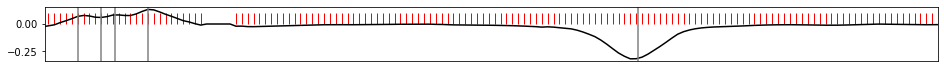

In [182]:

ds.plot_nv(nMSv, 2,fineW=1)
# plt.ylim(0.0, 0.1)
ds.plot_mask(ds.nmask,ax=plt.gca())
plt.xlim(3930,3990)
plot_lines()

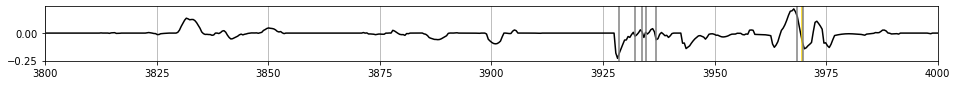

In [235]:
# ds.plot_mask(ds.nmask, fineW=1)
ds.plot_nv(nMSv, 8,fineW=1)
# plt.ylim(0.0, 0.1)
plt.xlim(3800,4000)
plt.vlines([],ymin=-0.25,ymax=0.2)

# plot_lines()

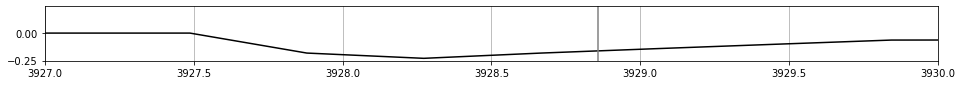

In [190]:
# ds.plot_mask(ds.nmask, fineW=1)
ds.plot_nv(nMSv, 8,fineW=1)
# plt.ylim(0.0, 0.1)
plt.xlim(3927,3930)
# plot_lines()
ax=plt.gca()
ax.axvline(3928.86 , c="gray", label="Fe I")


In [206]:
def plot_lines(ax=None):
    if ax is None: ax=plt.gca()
    ax.axvline(3928.57, c="gray", label="Fe I")
    ax.axvline(3969.59 , c="gold", label="Ca II" )    
    ax.axvline(3936.9264, c="gray", label="Fe I")
    ax.axvline(3969.84, c="gray", label="Fe III")
    ax.axvline(3932.23, c="gray", label="Fe I")
    ax.axvline(3933.74, c="gray", label="Fe I")
    ax.axvline(3934.72, c="gray", label="Fe I")
    ax.axvline(3968.5429, c="gray", label="Fe I")

        

(3900.0, 4000.0)

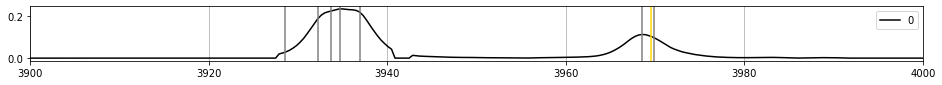

In [210]:
ds.plot_nv(nMSv, 0,fineW=1)
plt.legend()
# plot_lines()
plt.xlim(3900,4000)
ax.axvline(3934.72, c="gray", label="Fe I")
ax.axvline(3968.5429, c="gray", label="Fe I")
# plt.xlim(3964,3972)

# plt.ylim(0.0,0.12)

(3900.0, 4000.0)

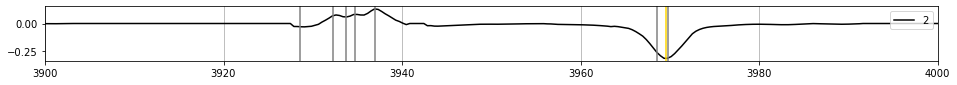

In [213]:
ds.plot_nv(nMSv, 2,fineW=1)
plt.legend(loc=1)
plot_lines()
plt.xlim(3900,4000)
# plt.ylim(-0.32,-0.3)

In [ ]:
ds.plot_nv(nMSv, 8,fineW=1)
plt.legend(loc=1)
# plot_lines()
plt.vlines([3924.59,3931.98,3934.77,3936.4,3947.16,3950.02,3950.722,3958.17,3969.59,3973.69,3974.83],ymin=-0.25,ymax=0.2)
plt.xlim(3900,4000)

(3900.0, 4000.0)

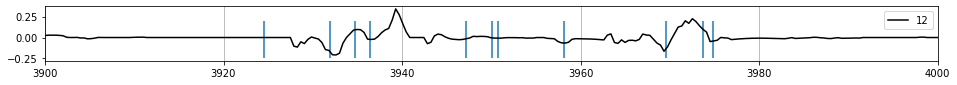

In [231]:
ds.plot_nv(nMSv, 12,fineW=1)
plt.legend(loc=1)
# plot_lines()
# plt.axvline(4369.12)
# plt.axvline(4368.8)

# plt.vlines([3934, 3968],ymin=-0.25,ymax=0.2)
plt.vlines([3924.59,3931.98,3934.77,3936.4,3947.16,3950.02,3950.722,3958.17,3969.59,3973.69,3974.83],ymin=-0.25,ymax=0.2)
plt.xlim(3900,4000)
# plt.ylim(-0.,0.15)

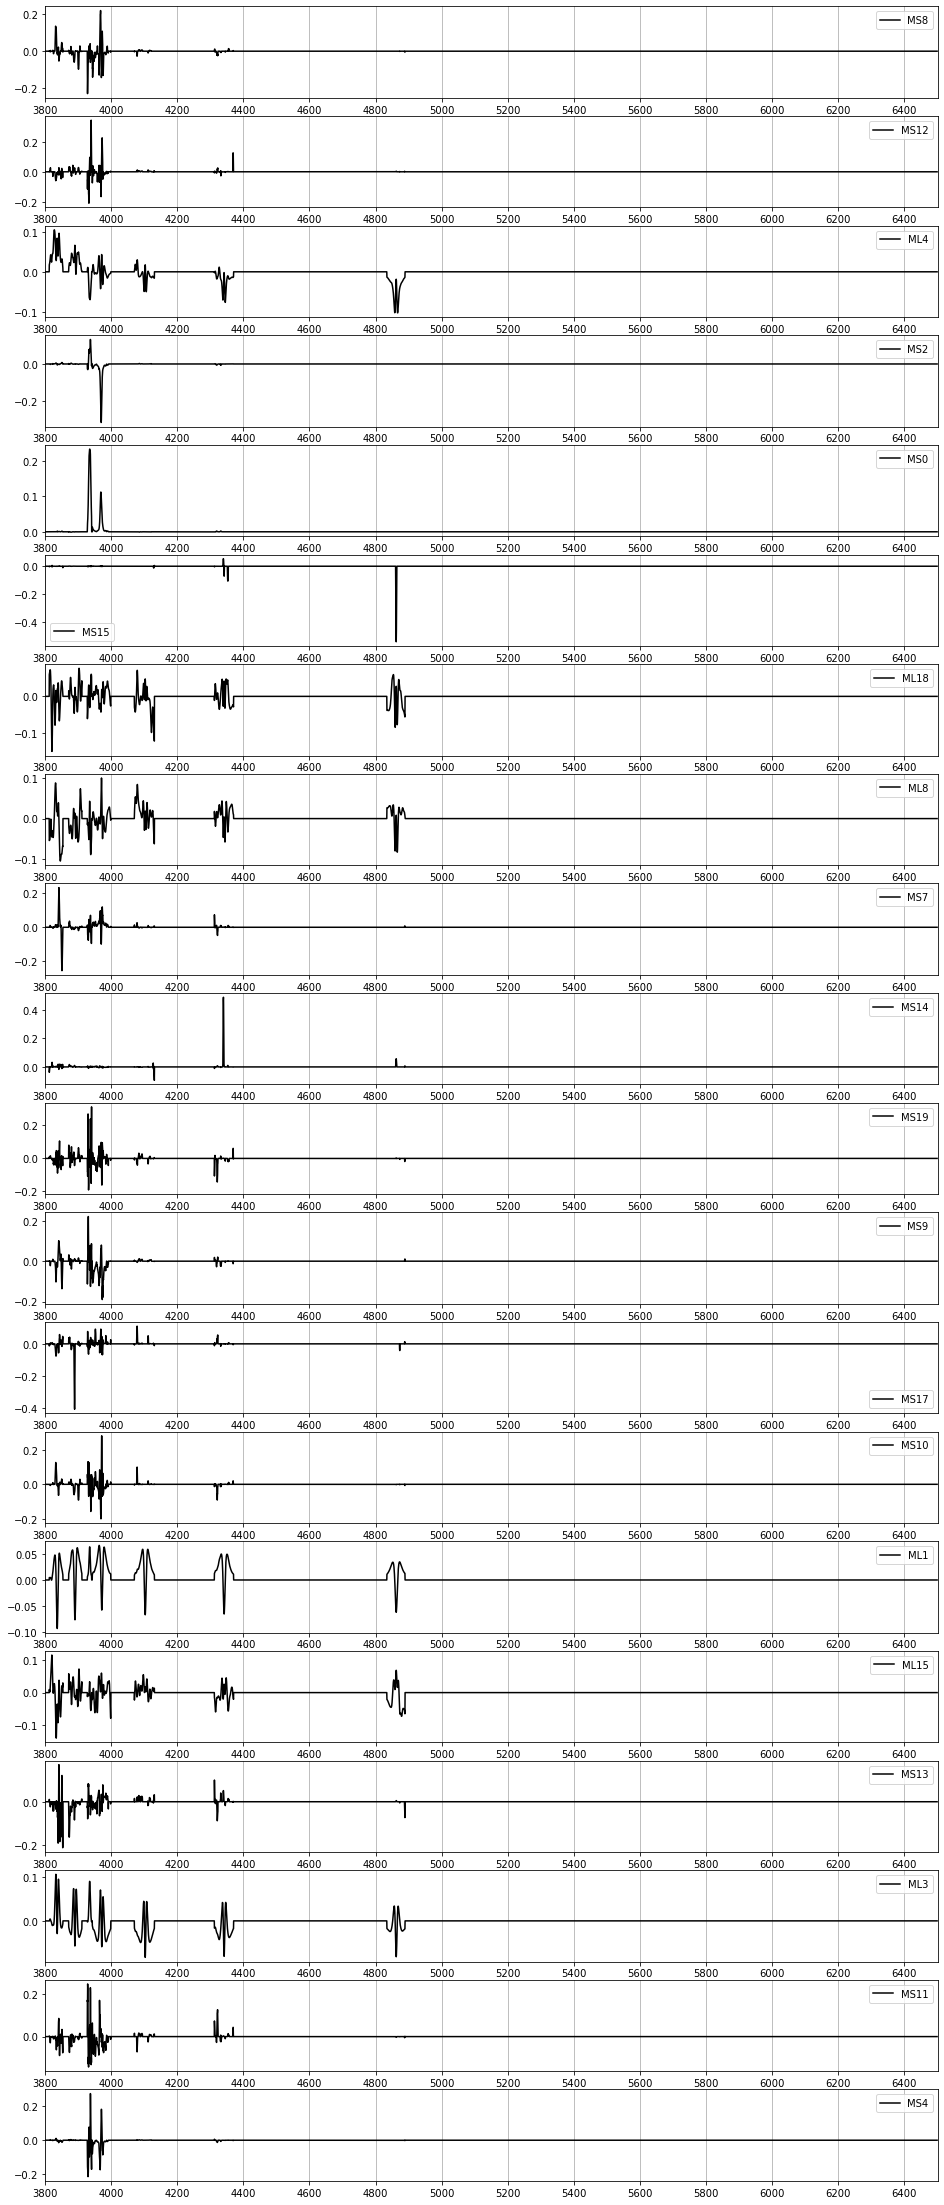

In [119]:
ds.plot_nvs(ds.nXv, sdx, nidxs=ds.Xname)

/home/swei20/LV/nb/../lv/base/dataloader_c.py:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  v = nvs[idx]


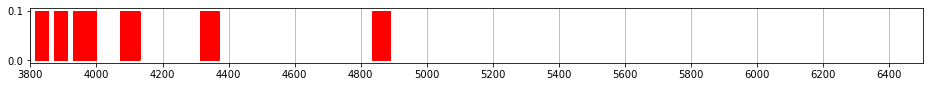

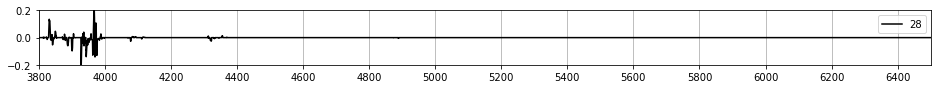

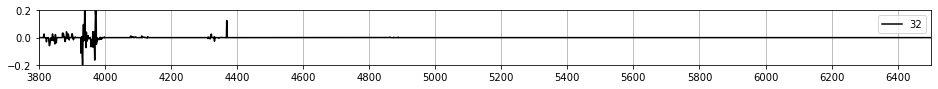

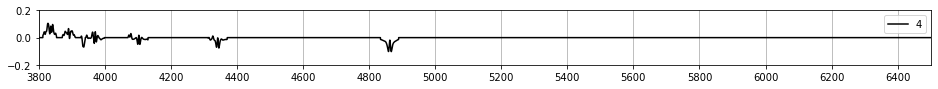

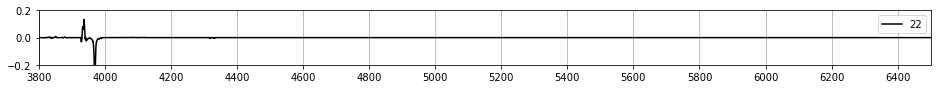

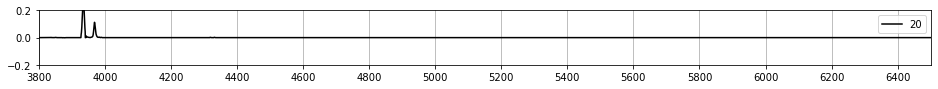

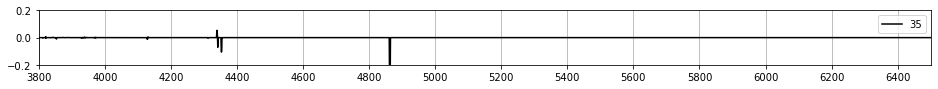

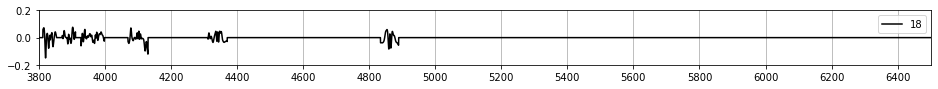

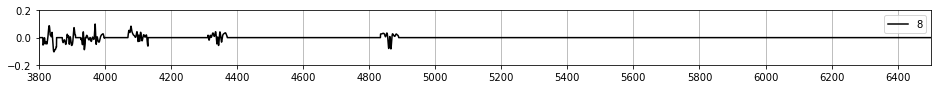

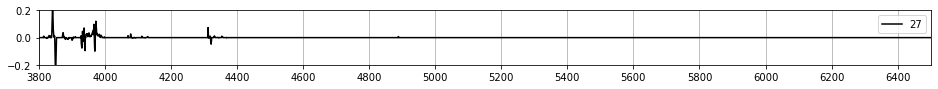

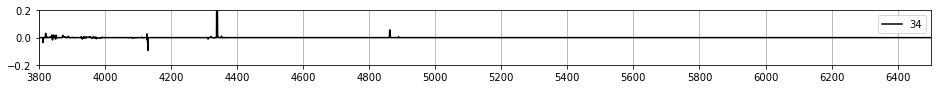

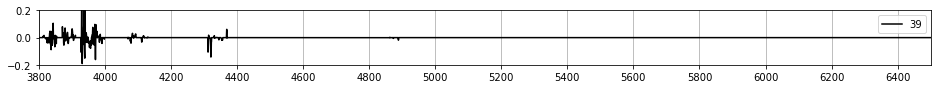

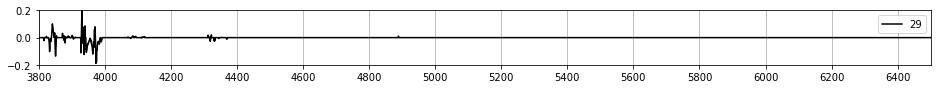

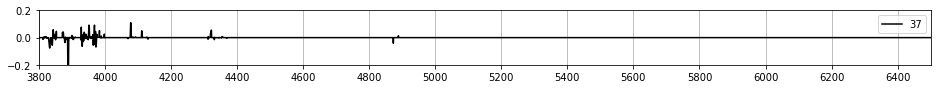

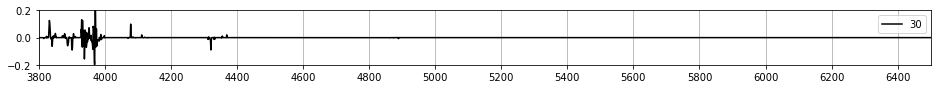

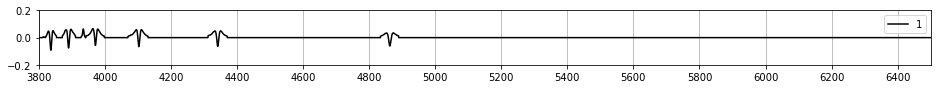

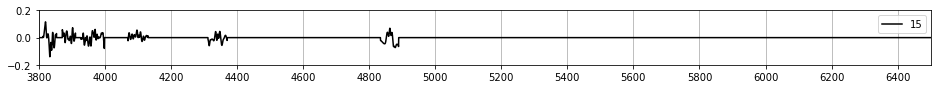

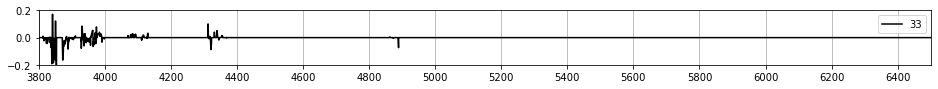

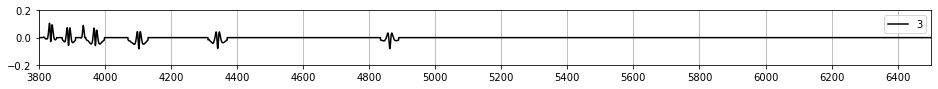

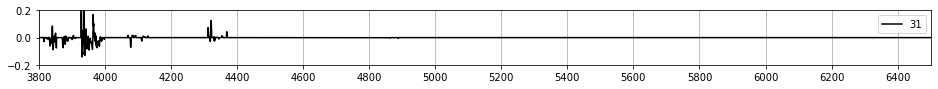

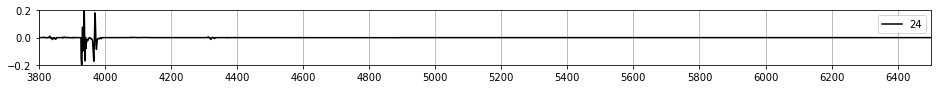

In [103]:
ds.plot_mask(ds.nmask)
for i in range(20):
    ds.plot_nv(ds.nXv, sdx[i])
    plt.ylim(-0.2,0.2)
    plt.legend()

(3800.0, 4000.0)

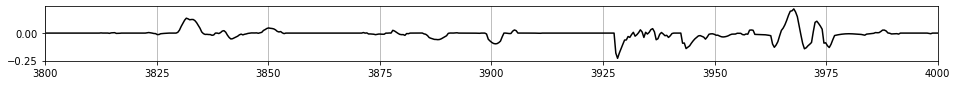

In [84]:
ds.plot_nv(nMSv, 8, fineW=1)
plt.xlim(3800, 4000)

(3800.0, 4000.0)

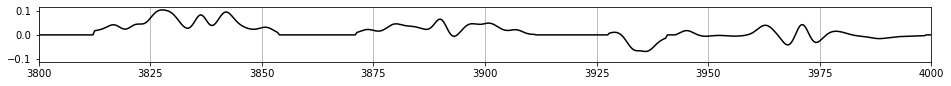

In [88]:
ds.plot_nv(nMLv, 4, fineW=1)
plt.xlim(3800, 4000)

(3800.0, 4000.0)

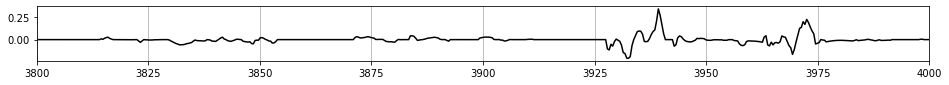

In [85]:
ds.plot_nv(nMSv, 12, fineW=1)
plt.xlim(3800, 4000)

In [ ]:
for i in range(60):
#     idx = a[:,5:25].reshape(-1)
    ds.plot_nv(ds.nXv, s[i])
    plt.legend()

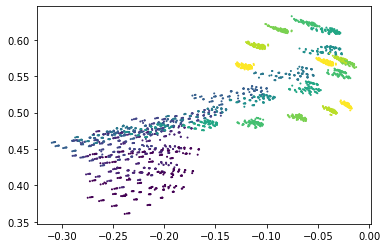

In [87]:
plt.scatter(ds.npcpFlux[:,sdx[0]], ds.npcpFlux[:, sdx[1]],  c=ds.para[:,idx],s=1)

In [74]:
sdx

array([13, 16, 12,  9, 14,  2, 19,  7, 17,  6, 11, 10, 26, 25, 23, 38,  5,
       21, 36,  0])

In [ ]:
plt.scatter(ds.npcpFlux[:,sdx[-1]], ds.npcpFlux[0],  c=)

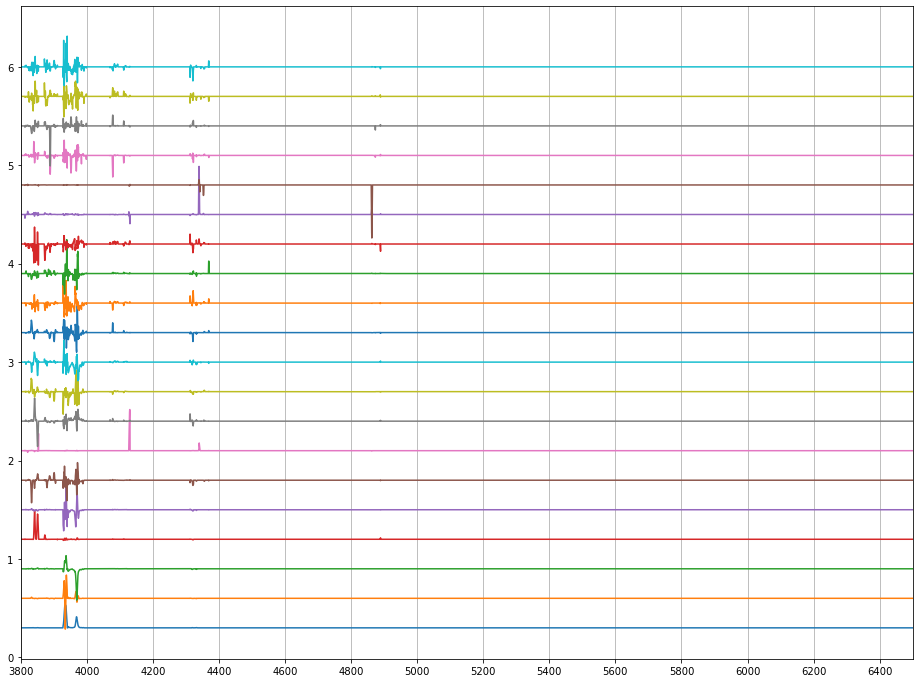

In [68]:
ds.plot_V(nMSv, top=20)